# Section 1 - Introduction
The goal of this notebook is to get started up with OpenAI's Gymnasium library and to implement a simple Q-Learning Reinforcement Learning algorithm in the Lunar Lander environment.

## Section 1.1 - Agent-Environment Interface
Recall the components of a RL problem:

![agent_environment_interface](Images/agent_environment_interface.png)
*Reference: Sutton, R. S., Bach, F., &amp; Barto, A. G. (2018). ch3.1, pg 64. In Reinforcement learning: An introduction. essay, MIT Press Ltd.*

The *Agent* is the entity which interacts with the environment and learns to behave in a way that maximizes its cumulative rewards. The *Environment* is everything outside the *Agent*. It is the world that the *Agent* interacts with and learns from.

## Section 1.2 - Markov Decision Process (MDP)
[Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process) (MDP) are the foundation of Reinforcement Learning. MDPs are mathematical frameworks for modelling sequential decision making problems where outcomes are partly random and partly under the control of a decision-maker, or an *Agent*.


A Markov Decision Process is defined by the tuple $<S, A, T, R>$ where:
- $S$ is the set of states within the environment
- $A$ is the set of possible actions that can be performed by the agent within the environment
- $T$ is the transitional probability model of transitioning from a state to another when taking a particular action
- $R$ is the reward function given desired state and action

Additionally, $\pi$ is the policy that seeks to solve the MDP by maximizing the cumulative reward obtained. In simpler terms, it maps states to actions, indicating the best action $a$ to take while in state $s$.

# Section 2 - Gym vs. Gymnasium
Not to be confused between OpenAI [Gym](https://github.com/openai/gym) and [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) maintained by Farama Foundation - **Gym** is a toolkit for developing and comparing RL algorithms while providing a wide range of environments while **Gymnasium** is a library built on top of TensorFlow, focused on providing environments for Deep RL research. It may be important to note that **Gym** is no longer being actively maintained, while **Gymnasium** is being actively maintained by the Farama Foundation.

**In this notebook, we would be utilizing Gymnasium**.

## Section 2.1 - Environment: Taxi
### Section 2.1.1 Description
The environment we would be using would be the [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) environment packaged in **Gymnasium**.

![SegmentLocal](Images/taxi.gif)

Based on the [documentation](https://gymnasium.farama.org/environments/toy_text/taxi/)

![taxi-information](Images/taxi_information.png)

*Description: There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.*

*The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.*

*The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.*

### Section 2.1.2 - Action Space
There are 6 discrete actions available:
- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

### Section 2.1.3 - Observation Space
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Destination on the map are represented with the first letter of the color.

Passenger locations:
- 0: Red
- 1: Green
- 2: Yellow
- 3: Blue
- 4: In taxi

### Section 2.1.4 - Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info. The episode receives additional reward of -100 or +100 for crashing or landing safely respectively. Episode is considered a solution if it scores at least 200 points.

### Section 2.1.5 - Starting States
The episode starts with the player in a random state.

### Section 2.1.6 - Episode Termination
The episode ends if the following happens:

- Termination: 1. The taxi drops off the passenger.
- Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.

# Section 3 - Setting Up
First, let's install the Gymnasium package containing the **Lunar Lander** environment.

In [4]:
!pip install 'gymnasium[box2d]'

  Obtaining dependency information for gymnasium[box2d] from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for numpy>=1.21.0 from https://files.pythonhosted.org/packages/d2/2f/b42860931c1479714201495ffe47d74460a916ae426a21fc9b68c5e329aa/numpy-1.26.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.26.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (53 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Obtaining dependency information for typing-extensions>=4.3.0 from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5

In [5]:
# import gymnasium as gym

In [6]:
""" # Uncomment this to test only
env = gym.make('LunarLander-v2', render_mode='human')
observation, info = env.reset()
episodes = 0

while episodes < 5:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        observation, info = env.reset()
        episodes += 1
    
env.close()
"""

# Section 4 Q-Learning
## Section 4.1 - Return
The *Return* is defined as the total discounted reward from the current time-step.
$$
G_t = R_{t+1} + \gamma R_{t+2} + ... = \sum^{\infty}_{k=0}\gamma^kR_{t+k+1}
$$
where $\gamma$ is the discount factor.

## Section 4.2 - Q-Value
The Q-value is defined as the expected return of taking a particular action in a particular state while policy a particular policy.
$$
q_\pi(s,a) := \mathop{\mathbb{E}}_\pi(G_t | S_t=s, A_t=a) \\
= \mathop{\mathbb{E}}_\pi[\sum^{\infty}_{k=0}\gamma^kR_{t+k+1} | S_t=s]
$$
Under the optimal policy, the Bellman Optimality Equation is satisfied:
$$
q_*(s,a) := \mathop{\mathbb{E}}[R_{t+1}+\gamma \max_{a'}q_*(s',a')]
$$
## Section 4.3 - Q-Learning Algorithm
Q-Learning is a *model-free*, *policy-free* Reinforcement Learning algorithm which seeks to learn the optimal policy by estimating the Q-value(state-action pair) function represented in the Bellman Optimality Equation above. The algorithm is *model-free* as it does not rely on a transitional probablity model, and *policy-free* as it follows a greedy policy instead of one of its own.

Learning can be done iteratively by storing all Q-values in a table that will be updated at each time step using the Q-Learning iteration:
$$
q^\text{new}(s,a) = (1-\alpha)\overbrace{q(s,a)}^\text{old value} + \alpha\underbrace{(R_{t+1}+\gamma\max_{a'}q(s',a'))}_\text{learned value}
$$

$\alpha$ represents the *learning rate*, a hyperparameter which controls the convergence.

## Section 4.4 - Exploration Exploitation Tradeoff
The exploration-exploitation tradeoff is a dilemma which many domains face. In Reinforcement Learning, *Exploration* refers to taking an action at every time-step which allows the agent to gain more knowledge with the possiblity of discovering an action netting more returns. *Exploitation* on the other hand focuses on **taking the action currently known to net the highest returns** at every time-step.

*Exploration* is important as it helps us to avoid converging to a local maximum, which is usually far from the optimal solution. To handle this, we use a threshold which decay every episode using [exponential decay](https://en.wikipedia.org/wiki/Exponential_decay):
$$
N(t) = N_0e^{-\lambda t}
$$
*Where $N_0$ is the initial value and $\lambda$ is the decay constant.*


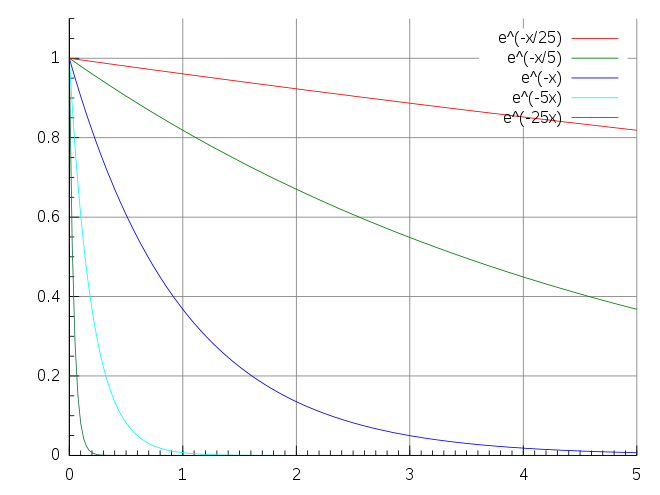
<center>Exponential Decay curves</center><br>

The reason behind the decaying threshold is to ensure that the agent exploration occurs more frequently at earlier time-steps and *exploitation* occurs more frequently at later time-steps, while still maintaining a chance of *exploration* at later time-steps.

## Code
Now let's begin by setting up the `environment` and getting the sizes for both action and observation spaces.

In [1]:
!pip install 'gymnasium[toy_text]'
!pip install 'numpy'

In [1]:
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt

In [2]:
env = gym.make('Taxi-v3')
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
env = gym.wrappers.TimeLimit(env, max_episode_steps=200)

n_observations = env.observation_space.n
n_actions = env.action_space.n

print(f'n_observations = {n_observations}')
print(f'n_actions = {n_actions}')

n_observations = 500
n_actions = 6


Next we define the hyperparameters to be used.

In [3]:
# Number of episodes to be run
n_episodes = 10000

# Number of iterations to be run
max_iter_episode = 200

exploration_probability = 1.0

# decay constant to calculate new exploration probability
decay_constant = 0.001

# Exploration probabaility threshold
exploration_threshold = 0.01

# Discount factor
gamma = 0.99

# Learning rate
alpha = 0.1

We also need to initialize a Q-table to track the Q-values of each state-action pairs. At the same time, we initialize a list to track the rewards received after each episode.

In [4]:
# Q-table
Q_table = np.zeros((n_observations, n_actions))

# Track rewards after each episode
episodic_returns = list()

Next we define the exponential decay function which returns the new exponential decay. Recall:
$$
N(t) = N_0e^{-\lambda t}
$$
*Where $N_0$ is the initial value and $\lambda$ is the decay constant.*

In [5]:
def calculate_exploration_prob(timestep):
    return exploration_probability * np.exp(-decay_constant * timestep)

and the Q-value function which calculates the new Q-value given state-action pairs:
$$
q^\text{new}(s,a) = (1-\alpha)\overbrace{q(s,a)}^\text{old value} + \alpha\underbrace{(R_{t+1}+\gamma\max_{a'}q(s',a'))}_\text{learned value}
$$
$\alpha$ represents the *learning rate*, a hyperparameter which controls the convergence.

In [6]:
def Q_function(state, action, next_reward, next_state):
    return (1.0-alpha) * Q_table[state, action] + alpha * (next_reward + gamma * max(Q_table[next_state,:]))

Now we can define the loop where all the process happens.

In [7]:
for episode in range(n_episodes):
    # Initialize the start of each episode which returns an observation(state) and auxiliary information
    current_state, _ = env.reset()
    n_iterations = 0
    
    # Initialize variables to track if episode has ended
    ## This is possible as we wrapped our environment with the 'TimeLimit' wrapper
    terminated = False
    truncated = False
    
    # Initialize the return in the current episode
    current_return = 0
    
    while(not (terminated or truncated)):
        # Sample a probability from a uniform distribution over 0 and 1 and compare it
        # to the current exploration probability.
        if np.random.uniform(0,1) < max(exploration_threshold, calculate_exploration_prob(episode)):
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
            
        # Run the selected action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Learning: Update Q-table using Q-Learning iteration
        Q_table[current_state, action] = Q_function(current_state, action, reward, next_state)
        current_return += reward
        
        # Set current state as next state
        current_state = next_state
    
    # Decay exploration probability
    #exploration_probability = max(exploration_threshold, calculate_exploration_prob(i))
    # Append episodic return to logging list
    episodic_returns.append(current_return)

Here we plot the mean episodic returns for every 100 episodes to visualize the *learning* in the agent.
*Note: We use the mean as there might be huge fluctuations in the values due to the exploration.*

Text(0, 0.5, 'Return')

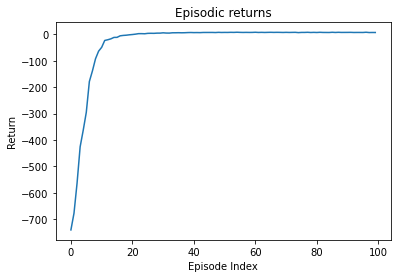

In [8]:
# Calculate mean return for every 100 episodes
mean_episodic_returns = list()
window_size = 100 # Sliding window concept
for i in range(0, len(episodic_returns), window_size):
    # Each chunk contains the next 100 values
    chunk = episodic_returns[i:i+window_size]
    # Compute mean and append to list
    chunk_mean = np.mean(chunk)
    mean_episodic_returns.append(chunk_mean)

plt.plot(list(range(0, len(mean_episodic_returns))), mean_episodic_returns)
plt.title('Episodic returns')
plt.xlabel('Episode Index')
plt.ylabel('Return')

Based on this visualization, we can see that the performance of the agent is not efficient in the beginning but improves over episodes. Let's see how our trained agent perform in a rendered environment.

In [9]:
rendered_env = gym.make('Taxi-v3', render_mode='human')

# Single episode
truncated = False
terminated = False

for i in range(10): # Run 10 episodes since env takes time to render
    current_state, _ = rendered_env.reset()
    while (not (truncated or terminated)):
        current_state, reward, terminated, truncated, _ = rendered_env.step(np.argmax(Q_table[current_state,:]))

# Conclusion
Q-learning algorithm is an efficient way for an agent to learn the environment, however the method that was presented here utilizes the tabular method to store Q-values. In continuous state or action spaces, this would not suffice. We will see how we are able to utilize Deep Neural Networks(DNN) to approximate the Q-function, also known as Deep Q-Learning.